In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, ConductanceOptions, FilterParameters, OptimizationParameters
from act.data_processing import get_summary_features, combine_data

In [2]:
# Define the cell
cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

target_g = np.array([0.0003, 0.12, 0.036])

In [60]:
grid_values = np.linspace(target_g - 0.5 * target_g, target_g + 0.5 * target_g, num = 40)

In [ ]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

index_counter = 0
for g_na_value in grid_values[:, 1]:
    for g_k_value in grid_values[:, 2]:
        cell = ACTCellModel(
        cell_name = "Spiker",
        path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
        path_to_mod_files = "../../data/Spiker/orig/modfiles/",
        passive = ["gl", "el", None],
        active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
        )
        
        cell.set_g_bar(["hh_spiker.gnabar", "hh_spiker.gkbar"], [g_na_value, g_k_value])

        sim_params = SimulationParameters(
            sim_name = "cell",
            sim_idx = index_counter,
            h_celsius = 6.3,
            h_dt = 0.1,
            h_tstop = 1000,
            CI = [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0)])
        index_counter += 1
        
        simulator.submit_job(cell, sim_params)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [62]:
simulator.run_jobs(5)

In [63]:
# Combine simulated traces into one dataset for convenience
combine_data("output/cell")

output/cell/combined_out.npy


In [64]:
data = np.load("output/cell/combined_out.npy")
V = data[:, :, 0][:, ::10]
g = data[:, :2, 2]

In [65]:
estimated_sf = get_summary_features(V, [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0)] * len(g))

In [66]:
simulator = ACTSimulator(output_folder_name = "output")

cell = ACTCellModel(
        cell_name = "Spiker",
        path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
        path_to_mod_files = "../../data/Spiker/orig/modfiles/",
        passive = ["gl", "el", None],
        active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
        )

sim_params = SimulationParameters(
sim_name = "cell",
sim_idx = 999,
h_celsius = 6.3,
h_dt = 0.1,
h_tstop = 1000,
CI = [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0)])

simulator.submit_job(cell, sim_params)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [67]:
data = np.load("output/cell/out_999.npy")
V = data[::10, 0].reshape((1, -1))
target_sf = get_summary_features(V, [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0)])

In [160]:
# Z-transform the features
pred = estimated_sf.to_numpy()
z_mean = np.nanmean(pred, axis = 0)
z_std = np.nanstd(pred, axis = 0)

pred = (pred - z_mean) / z_std

# Use sample mean and std for target transformation
targ = target_sf.to_numpy() 
targ = (targ - z_mean) / z_std

mae = np.nanmean(np.abs(targ - pred), axis = 1)

/var/folders/gs/_z8_31zd6xz_w20ny978y50w0000gn/T/ipykernel_81040/157144236.py:6: RuntimeWarning: invalid value encountered in divide
  pred = (pred - z_mean) / z_std
/var/folders/gs/_z8_31zd6xz_w20ny978y50w0000gn/T/ipykernel_81040/157144236.py:10: RuntimeWarning: invalid value encountered in divide
  targ = (targ - z_mean) / z_std


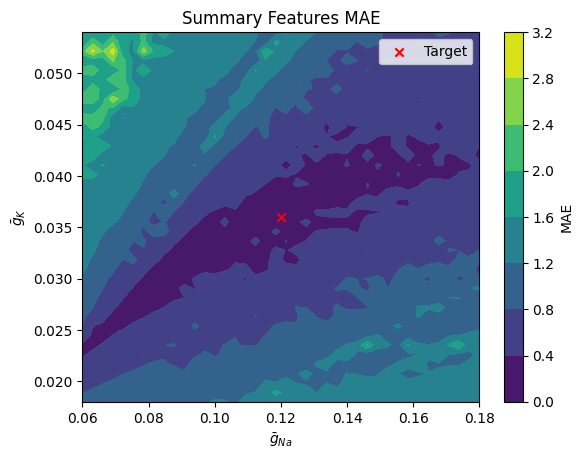

In [169]:
X, Y = np.meshgrid(grid_values[:, 1], grid_values[:, 2], indexing = 'ij')

fig, ax = plt.subplots()
contour = ax.contourf(X, Y, mae.reshape((grid_values.shape[0], grid_values.shape[0])), cmap = 'viridis')
ax.scatter(target_g[1], target_g[2], marker = "x", color = 'red', label = "Target")

ax.set_xlabel(r"$\bar{g}_{Na}$")
ax.set_ylabel(r"$\bar{g}_{K}$")
ax.set_title('Summary Features MAE')
ax.legend()

cbar = fig.colorbar(contour)
cbar.set_label('MAE')

In [2]:
from act.module import ACTModule

In [ ]:
cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

target_g = np.array([0.0003, 0.12, 0.036])

sim_params = SimulationParameters(
        sim_name = "cell",
        sim_idx = 0,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0)])

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gl", low = 0, high = 1, n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = 0, high = 1, n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = 0, high = 1, n_slices = 3),  
    ],
    train_features = None,
    prediction_eval_method = 'fi_curve',
    spike_threshold = 0,
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    ),
    first_n_spikes = 20,
    random_state = 123,
    save_file = f"output/spiker_orig/results/saved_metrics.json"
)

In [4]:
m = ACTModule(
    name = "orig_module",
    cell = cell,
    simulation_parameters = sim_params,
    optimization_parameters = optim_params,
    target_file = "/Users/vladimiromelyusik/ACT/experiments/Spiker/output/target/combined_out.npy"
)

In [5]:
m.run()

Running Module orig_module...
----------
Simulating train traces...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
[(0.0, 0.0, 0.0), (0.0, 0.0, 0.5), (0.0, 0.0, 1.0), (0.0, 0.5, 0.0), (0.0, 0.5, 0.5), (0.0, 0.5, 1.0), (0.0, 1.0, 0.0), (0.0, 1.0, 0.5), (0.0, 1.0, 1.0), (0.5, 0.0, 0.0), (0.5, 0.0, 0.5), (0.5, 0.0, 1.0), (0.5, 0.5, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 1.0), (0.5, 1.0, 0.0), (0.5, 1.0, 0.5), (0.5, 1.0, 1.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.5), (1.0, 0.0, 1.0), (1.0, 0.5, 0.0), (1.0, 0.5, 0.5), (1.0, 0.5, 1.0), (1.0, 1.0, 0.0), (1.0, 1.0, 0.5), (1.0, 1.0, 1.0)]
[(<act.cell_model.ACTCellModel object at 0x14b4690c0>, SimulationParameters(sim_name='train', sim_idx=0, h_v_init=-50, h_tstop=1000, h_dt=0.1, h_celsius=6.3, CI=[ConstantCurrentInjection(amp=0.5, dur=700, delay=100, lto_hto=0)], random_seed=42, _path='/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig_module/train')), (<act.

ValueError: 